In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import keras
from PIL import Image 
import keras.backend as K
from keras import Model
from keras.models import load_model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


### The Data

In [2]:
df_train = pd.read_csv('./input/severstal-steel-defect-detection/train.csv')

In [3]:
df_train['Defect'] = df_train['EncodedPixels'].notnull()
df_train['ClassId'] = df_train['ImageId_ClassId'].str[-1:]
df_train['ImageId'] = df_train['ImageId_ClassId'].str[:-2]

df_train = df_train[['ImageId','ClassId','Defect','EncodedPixels']]

In [4]:
df_train = df_train[df_train.Defect]
df_train = df_train.drop(['Defect'], axis=1)

In [5]:
df_train.shape

(7095, 3)

In [6]:
df_train.head(10)

ImageId ClassId                                      EncodedPixels
0   0002cc93b.jpg       1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
18  0007a71bf.jpg       3  18661 28 18863 82 19091 110 19347 110 19603 11...
20  000a4bcdd.jpg       1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
27  000f6bf48.jpg       4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
30  0014fce06.jpg       3  229501 11 229741 33 229981 55 230221 77 230468...
46  0025bde0c.jpg       3  8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
47  0025bde0c.jpg       4  315139 8 315395 15 315651 16 315906 17 316162 ...
51  002af848d.jpg       4  290800 6 291055 13 291311 15 291566 18 291822 ...
56  002fc4e19.jpg       1  146021 3 146275 10 146529 40 146783 46 147038 ...
57  002fc4e19.jpg       2  145658 7 145901 20 146144 33 146386 47 146629 ...

### Utility functions

In [7]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def rle2mask(rle, width, height):
    width = width
    height= height
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [73]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

### Load stored model

In [8]:
ORIG_IMG_SIZE_HEIGHT = 256
ORIG_IMG_SIZE_WIDTH = 1600
TRAIN_IMG_SIZE_HEIGHT = 256
TRAIN_IMG_SIZE_WIDTH = 1600

BATCH_SIZE = 4

NO_OF_CLASSES = 4

PATIENCE = 2
EPOCHS = 1


In [9]:
def dice_coeff(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    loss = 0.5 * binary_crossentropy(y_true, y_pred) - 2*dice_coeff(y_true, y_pred)
    return loss


In [10]:
model_256x1600 = load_model('./unet_model_256x1600_unsharp_4classes_v1.h5', 
                          custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coeff': dice_coeff})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [11]:
# Binarize the mask output by NN
def binarize(masks, th = 0.5):
    # Maximum value of each channel per pixel
    mask_max = np.zeros_like(masks[:,:,0])
    mask_max = np.fmax(masks[:,:,0],masks[:,:,1])
    mask_max = np.fmax(mask_max,masks[:,:,2])
    mask_max = np.fmax(mask_max,masks[:,:,3])
    # Remove non-maximum pixels
    m = np.zeros_like(masks)
    for ch in range(4):
        m[:,:,ch] = (masks[:,:,ch] == mask_max) * masks[:,:,ch]
    # Binarization
    m = (m>th) * 1
    return m

In [12]:
from skimage.filters import unsharp_mask

# Data generator with preprocessing
class ImgDataGenerator_V3_5(keras.utils.Sequence):
    
    def __init__(self, df, img_path, outcome_img_shape, n_channels=1, n_classes=1, 
                 img_normalize=False, img_center = False, img_standardize = False, 
                 use_unsharp_mask=False, unsharp_radius=1.0, unsharp_amount=1.0):
        super().__init__()
        self.df = df
        self.img_path = img_path
        self.outcome_img_shape = outcome_img_shape
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.use_unsharp_mask = use_unsharp_mask
        self.unsharp_radius = unsharp_radius
        self.unsharp_amount = unsharp_amount
        self.latest_processed = []
        
        self.datagen_img = ImageDataGenerator(data_format='channels_last', dtype='float32')

        self.datagen_mask = ImageDataGenerator(data_format='channels_last', dtype='bool')

        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.floor(len(self.df)))
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        

    def latest_processed(no_of_processed):
        return self.latest_processed[-no_of_processed:-1]
    
    
    def __getitem__(self, index): 
        X = np.empty((1,*self.outcome_img_shape, self.n_channels), dtype=np.float32)
        y = np.empty((1, *self.outcome_img_shape, self.n_classes), dtype=np.bool)
        
        #indexes = self.indexes[index:(index+1)]
        
        filename = self.df['ImageId'].iloc[index]
        self.latest_processed.append(filename)
        img = cv2.imread(self.img_path + filename, cv2.IMREAD_UNCHANGED)
        orig_img_shape = img.shape[0:2]
        if self.use_unsharp_mask:
            img = unsharp_mask(img, radius=self.unsharp_radius, amount=self.unsharp_amount)
        if orig_img_shape != self.outcome_img_shape:
            img = cv2.resize(img, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
        X[0,] = img

        mask = rle2mask(self.df['EncodedPixels'].iloc[index], *orig_img_shape)            
        if orig_img_shape != self.outcome_img_shape:
            mask = cv2.resize(mask, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
        y[0,:,:,(int(self.df['ClassId'].iloc[index]) - 1)] = mask
         
        seed = 13
        image_generator = self.datagen_img.flow(X, seed=seed, batch_size=1, shuffle=False)
        mask_generator = self.datagen_mask.flow(y, seed=seed, batch_size=1, shuffle=False)
        
        return zip(image_generator, mask_generator).__next__()


In [29]:
#idx = int(0.85*len(df_train))
dataGen_train_visual = ImgDataGenerator_V3_5(df_train.iloc[7010: 7015], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH),
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5)

print('Running predictions')
preds = model_256x1600.predict_generator(dataGen_train_visual,verbose=1)

print(preds.shape)

Running predictions
5/5 [==============================] - 24s 5s/step
(5, 256, 1600, 4)


In [14]:
def show_predict_img(index):
    img, mask = dataGen_train_visual.__getitem__(index)  
    print(img.shape)
    print(mask.shape)
    
    pred_masks = model_256x1600.predict(img)
    bin_masks = binarize(pred_masks[0, ...], 0.5)

    fig, axs = plt.subplots(5,2, figsize=(20, 12))
    axs[0,0].imshow(img[0])
    axs[0,0].axis('off')
    axs[0,0].set_title(f'Index: {index}')
    axs[0,1].axis('off')
    axs[0,1].set_title("after binarize")
    for i in range(4):
        axs[i+1,0].imshow(pred_masks[0,:,:,i])
        axs[i+1,0].axis('off')
        axs[i+1,0].set_title('class '+ str(i+1))
        axs[i+1,1].imshow(bin_masks[:,:,i])
        axs[i+1,1].axis('off')
        axs[i+1,1].set_title('class '+ str(i+1))

(1, 256, 1600, 3)
(1, 256, 1600, 4)


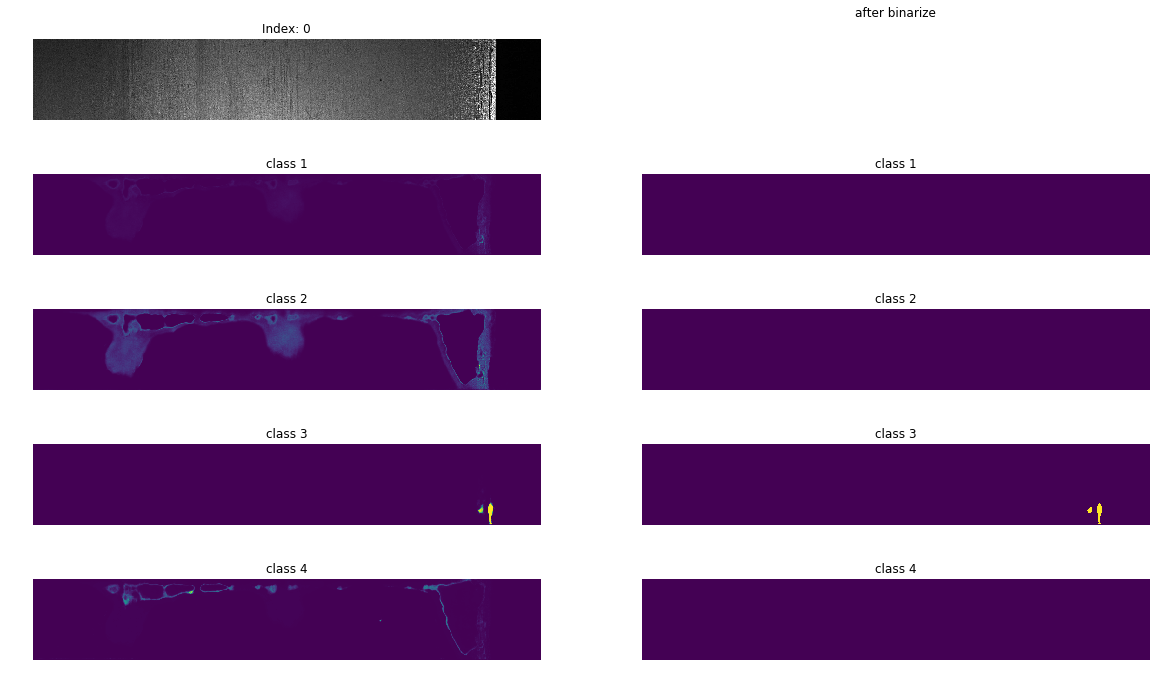

In [15]:
show_predict_img(0)

In [16]:
def mask2contour(mask, width=3):
    # CONVERT MASK TO ITS CONTOUR
    w = mask.shape[1]
    h = mask.shape[0]
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    return np.logical_or(mask2,mask3) 

def mask2pad(mask, pad=2):
    # ENLARGE MASK TO INCLUDE MORE SPACE AROUND DEFECT
    w = mask.shape[1]
    h = mask.shape[0]
    
    # MASK UP
    for k in range(1,pad,2):
        temp = np.concatenate([mask[k:,:],np.zeros((k,w))],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK DOWN
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((k,w)),mask[:-k,:]],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK LEFT
    for k in range(1,pad,2):
        temp = np.concatenate([mask[:,k:],np.zeros((h,k))],axis=1)
        mask = np.logical_or(mask,temp)
    # MASK RIGHT
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((h,k)),mask[:,:-k]],axis=1)
        mask = np.logical_or(mask,temp)
    
    return mask 

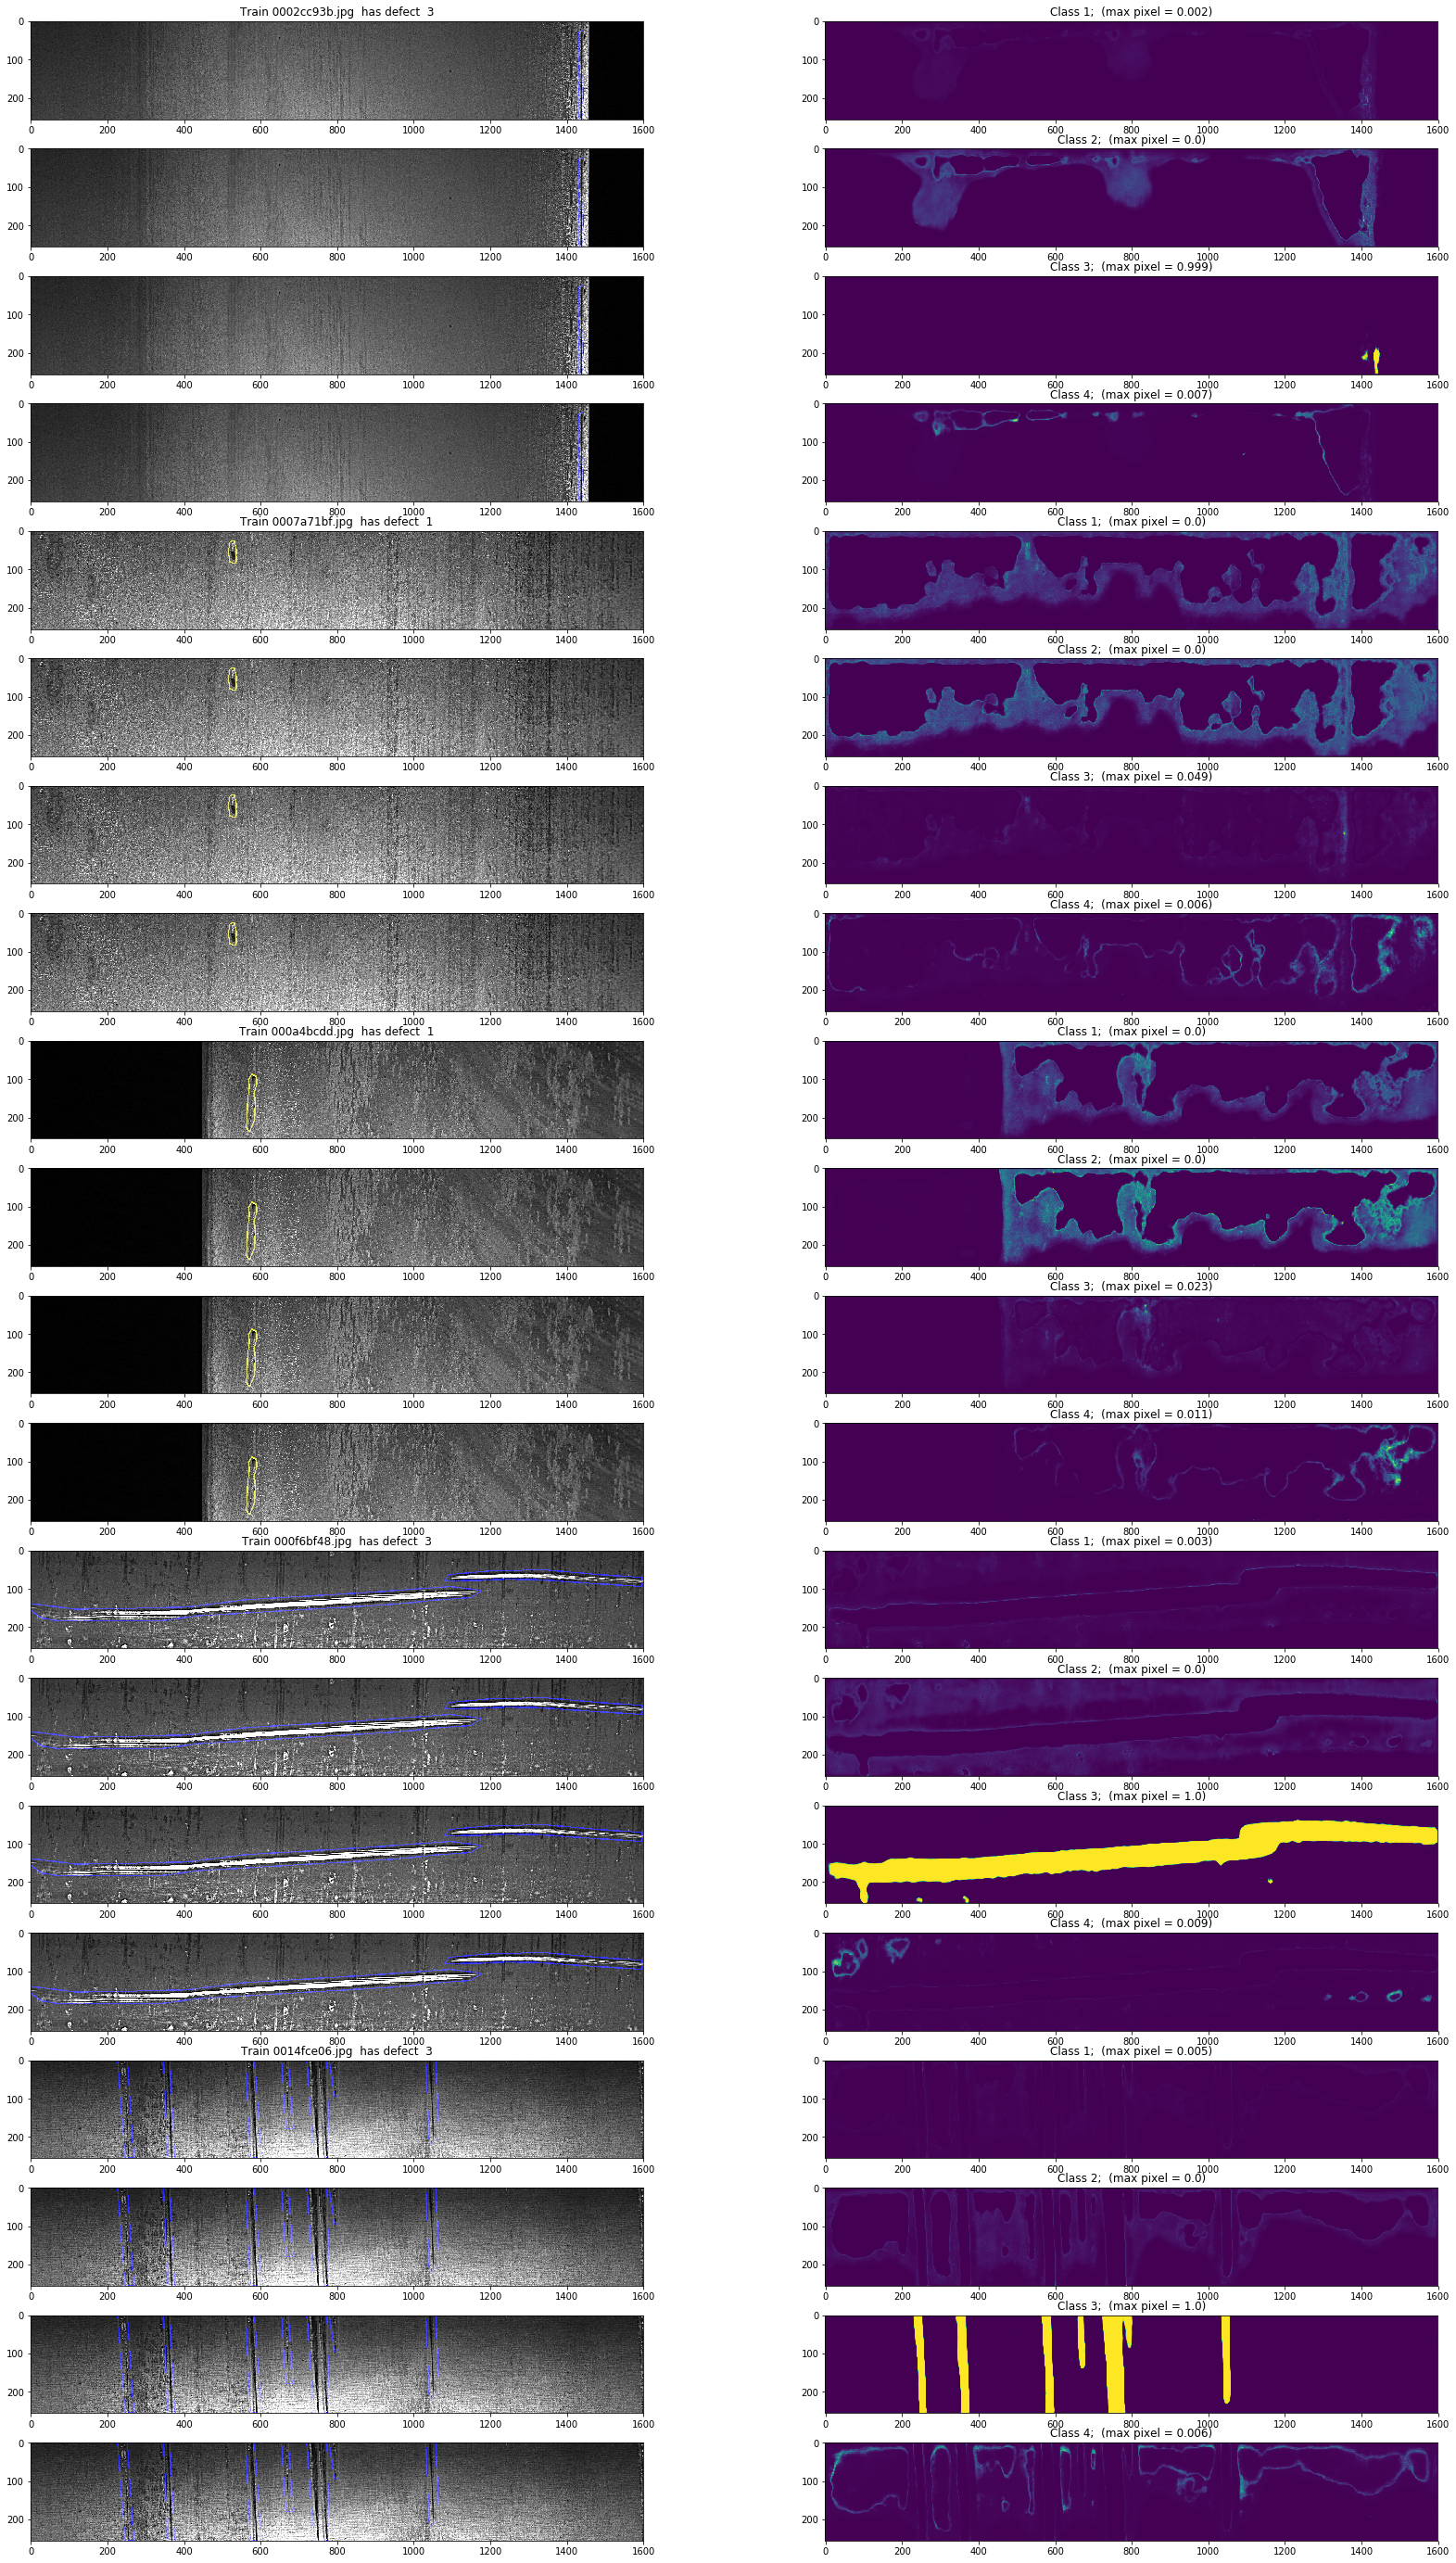

In [17]:
batch_size = 1
fig, axs = plt.subplots(20,2, figsize=(30, 50))
plt.subplots_adjust(hspace=0.3, wspace = 0.05)

for i,batch in enumerate(dataGen_train_visual):
    if i > 4:
        break
    for k in range(batch_size):
        img = batch[0][k,]
        img = np.array(img)
        img *= 255
        dft = 0
        extra = '  has defect '
        for j in range(4):
            msk = batch[1][k,:,:,j]
            if np.sum(msk)!=0: 
                dft=j+1
                extra += ' '+str(j+1)
            msk = mask2pad(msk,pad=2)
            msk = mask2contour(msk,width=3)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        
        if extra=='  has defect ': extra =''
        
        axs[i*4,0].imshow(Image.fromarray(img.astype('uint8')))
        axs[i*4+1,0].imshow(Image.fromarray(img.astype('uint8')))
        axs[i*4+2,0].imshow(Image.fromarray(img.astype('uint8')))
        axs[i*4+3,0].imshow(Image.fromarray(img.astype('uint8')))
        axs[i*4,0].set_title('Train ' + df_train.iloc[batch_size*i+k,0]+extra)
        
        for j in range(4):
            msk = preds[batch_size*i+k,:,:,j]
            axs[i*4+j,1].imshow(msk)
            mx = np.round(np.max(msk),3)
            axs[i*4+j,1].set_title('Class ' + str(j+1) + ';  (max pixel = ' + str(mx)+ ')')



(256, 1600, 4)
(256, 1600, 4)
(256, 1600, 4)
(256, 1600, 4)
(256, 1600, 4)
(256, 1600, 4)
(256, 1600, 4)
(256, 1600, 4)
(256, 1600, 4)
(256, 1600, 4)
(256, 1600, 4)
(256, 1600, 4)
(256, 1600, 4)
(256, 1600, 4)
(256, 1600, 4)
(256, 1600, 4)
(256, 1600, 4)
(256, 1600, 4)
(256, 1600, 4)
(256, 1600, 4)
Wall time: 2.89 s


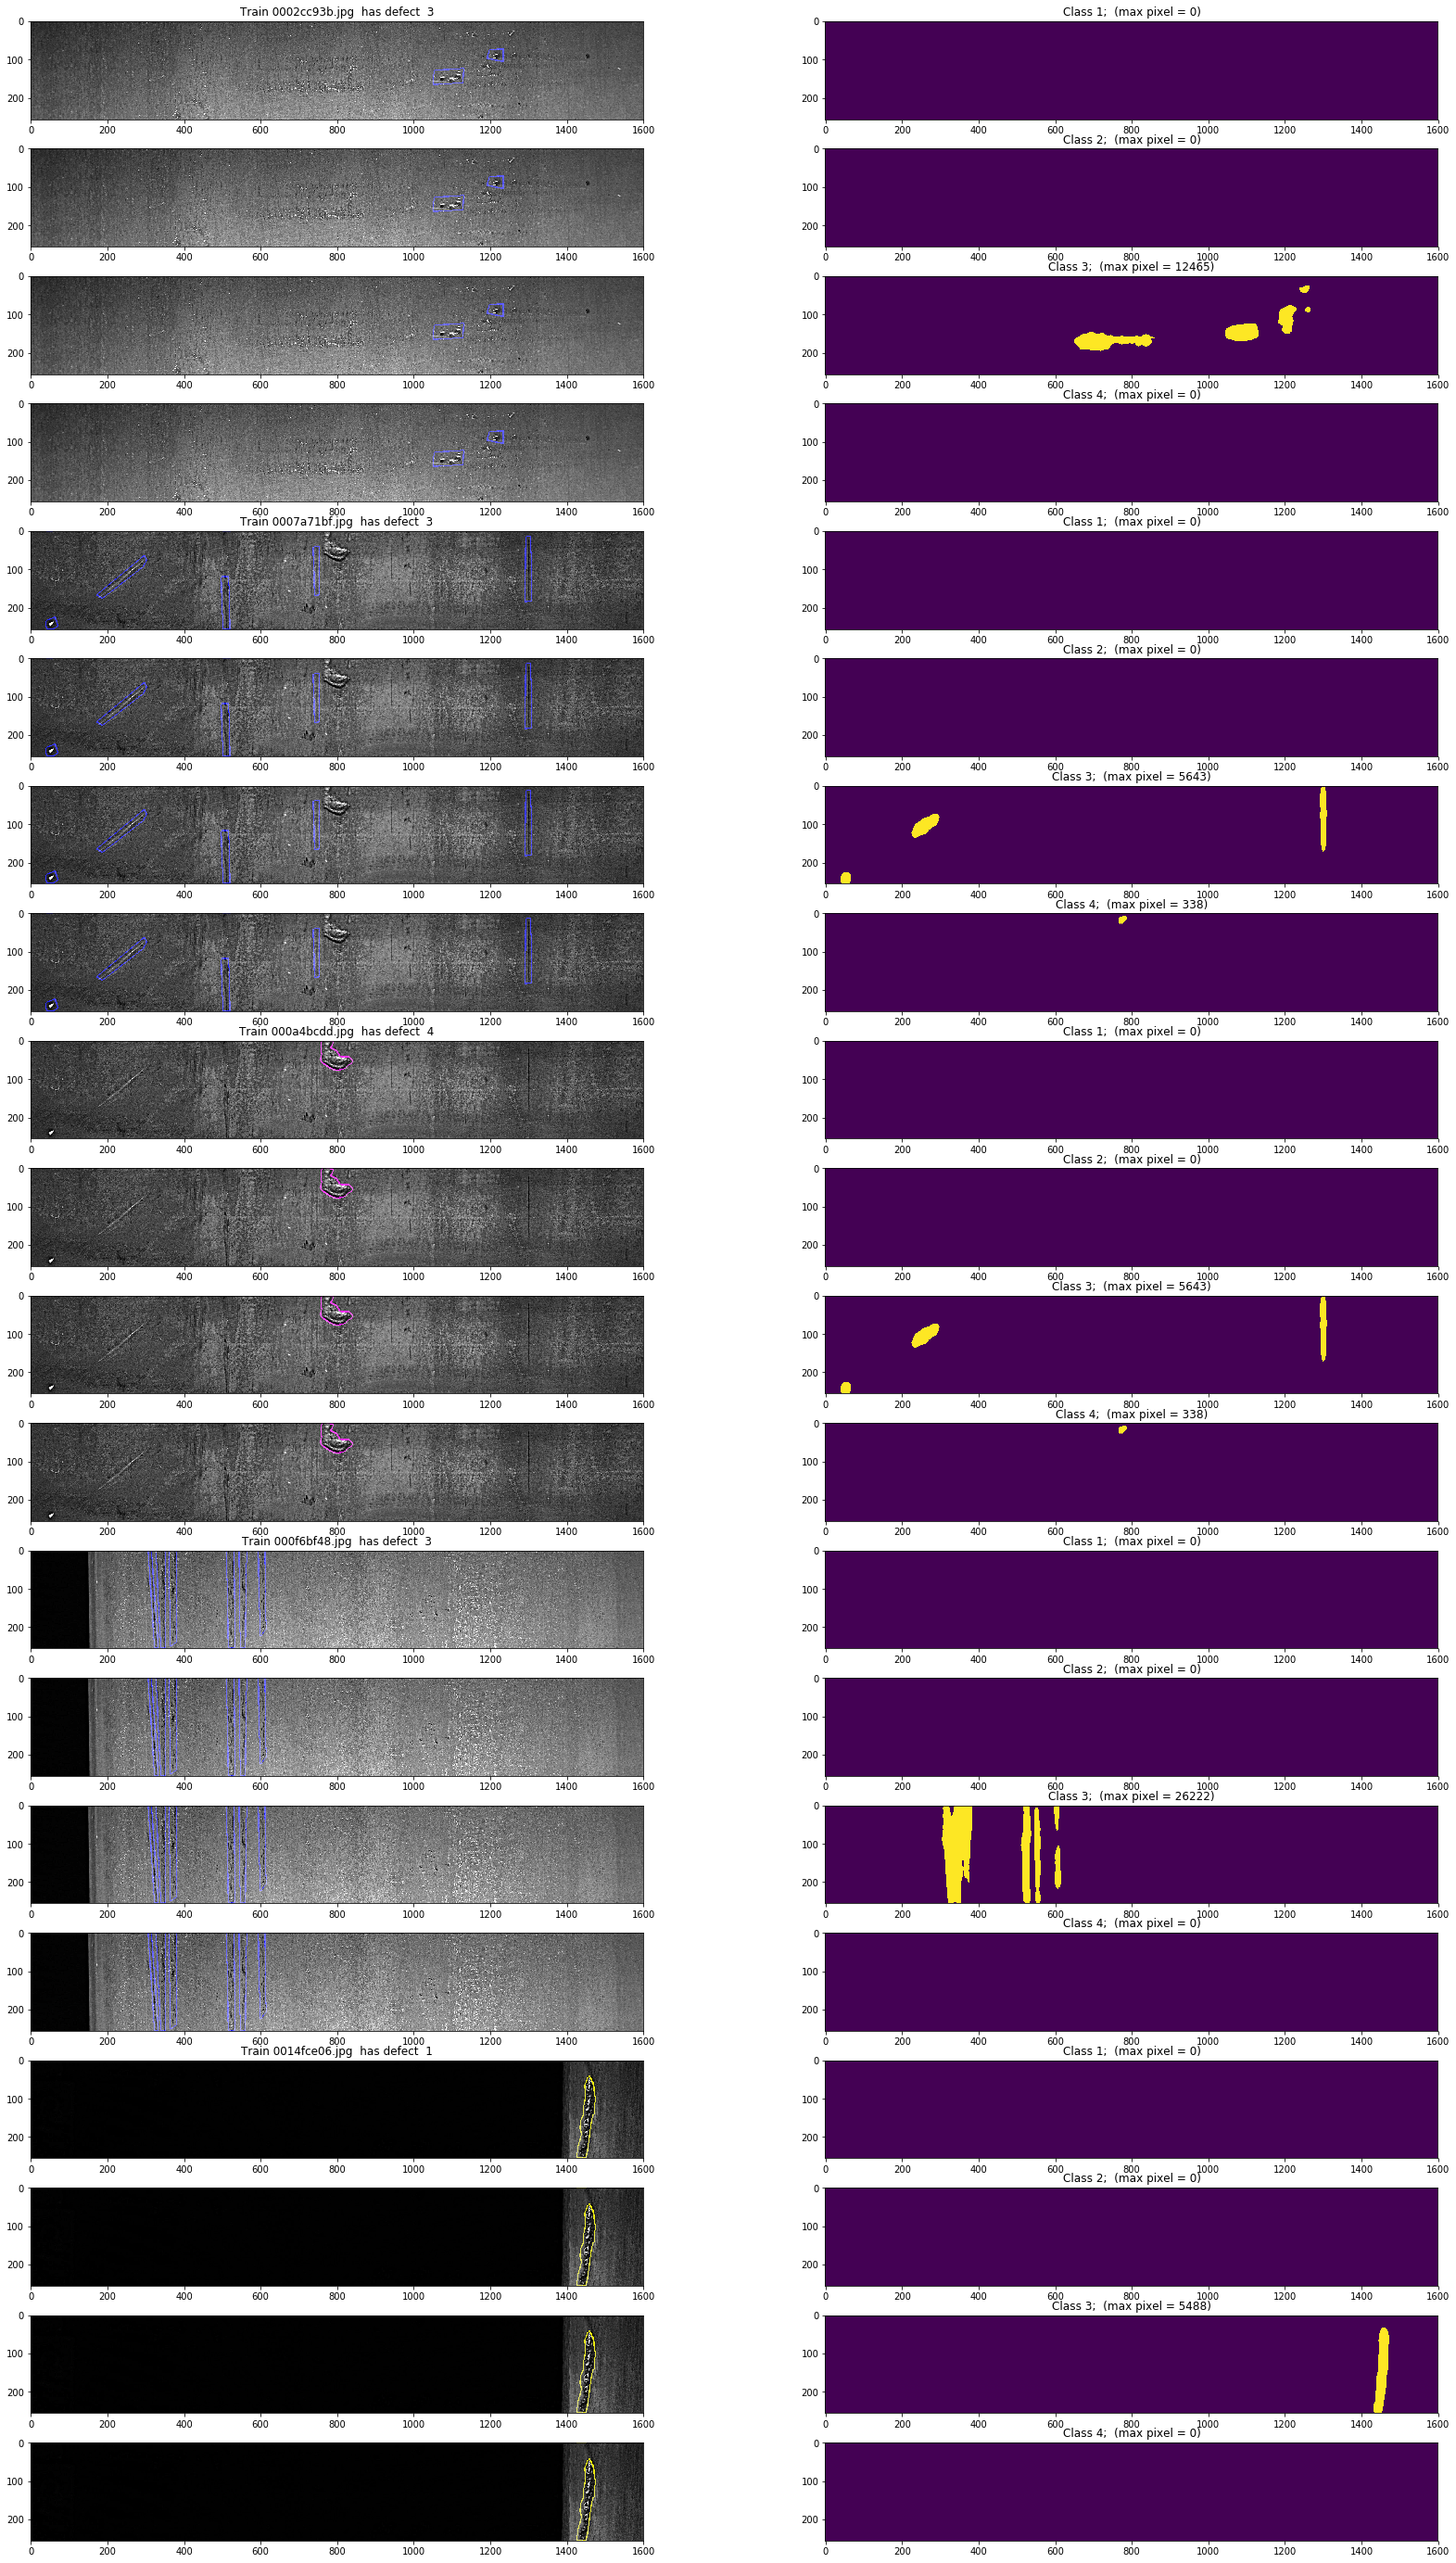

In [37]:
%%time
batch_size = 1
fig, axs = plt.subplots(20,2, figsize=(30, 50))
plt.subplots_adjust(hspace=0.3, wspace = 0.05)

for i,batch in enumerate(dataGen_train_visual):
    if i > 4:
        break
    for k in range(batch_size):
        img = batch[0][k,]
        img = np.array(img)
        img *= 255
        dft = 0
        extra = '  has defect '
        for j in range(4):
            msk = batch[1][k,:,:,j]
            if np.sum(msk)!=0: 
                dft=j+1
                extra += ' '+str(j+1)
            msk = mask2pad(msk,pad=2)
            msk = mask2contour(msk,width=3)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        
        if extra=='  has defect ': extra =''
        
        axs[i*4,0].imshow(Image.fromarray(img.astype('uint8')))
        axs[i*4+1,0].imshow(Image.fromarray(img.astype('uint8')))
        axs[i*4+2,0].imshow(Image.fromarray(img.astype('uint8')))
        axs[i*4+3,0].imshow(Image.fromarray(img.astype('uint8')))
        axs[i*4,0].set_title('Train ' + df_train.iloc[batch_size*i+k,0]+extra)
        
        msk = preds[batch_size*i+k,...]
        msk = binarize(msk, 0.5)
        for j in range(4):
            #msk = preds[batch_size*i+k,:,:,j]
            
            print(msk.shape)
            #msk = binarize(msk, 0.5)
            axs[i*4+j,1].imshow(msk[:,:,j])
            mx = np.round(np.sum(msk[:,:,j]),3)
            axs[i*4+j,1].set_title('Class ' + str(j+1) + ';  (max pixel = ' + str(mx)+ ')')



#### Create submission file

In [70]:
df_submission = pd.read_csv('./input/severstal-steel-defect-detection/sample_submission.csv')
df_submission.head(10)

ImageId_ClassId EncodedPixels
0  004f40c73.jpg_1           1 1
1  004f40c73.jpg_2           1 1
2  004f40c73.jpg_3           1 1
3  004f40c73.jpg_4           1 1
4  006f39c41.jpg_1           1 1
5  006f39c41.jpg_2           1 1
6  006f39c41.jpg_3           1 1
7  006f39c41.jpg_4           1 1
8  00b7fb703.jpg_1           1 1
9  00b7fb703.jpg_2           1 1

In [58]:
df_test = df_submission.copy()

df_test['ClassId'] = df_test['ImageId_ClassId'].str[-1:]
df_test['ImageId'] = df_test['ImageId_ClassId'].str[:-2]

df_test = df_test[['ImageId']].drop_duplicates()
print(df_test.shape)

(1801, 1)


In [59]:
df_test.head()

ImageId
0   004f40c73.jpg
4   006f39c41.jpg
8   00b7fb703.jpg
12  00bbcd9af.jpg
16  0108ce457.jpg

In [66]:
from skimage.filters import unsharp_mask

# Data generator with preprocessing
class ImgDataGenerator_predictor(keras.utils.Sequence):
    
    def __init__(self, df, img_path, outcome_img_shape, n_channels=1, n_classes=1, 
                 img_normalize=False, img_center = False, img_standardize = False, 
                 use_unsharp_mask=False, unsharp_radius=1.0, unsharp_amount=1.0):
        super().__init__()
        self.df = df
        self.img_path = img_path
        self.outcome_img_shape = outcome_img_shape
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.use_unsharp_mask = use_unsharp_mask
        self.unsharp_radius = unsharp_radius
        self.unsharp_amount = unsharp_amount
        self.latest_processed = []
        
        self.datagen_img = ImageDataGenerator(data_format='channels_last', dtype='float32')

        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.floor(len(self.df)))
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        

    def latest_processed(no_of_processed):
        return self.latest_processed[-no_of_processed:-1]
    
    
    def __getitem__(self, index): 
        X = np.empty((1,*self.outcome_img_shape, self.n_channels), dtype=np.float32)
        y = np.empty((1, *self.outcome_img_shape, self.n_classes), dtype=np.bool)
        
        filename = self.df['ImageId'].iloc[index]
        self.latest_processed.append(filename)
        img = cv2.imread(self.img_path + filename, cv2.IMREAD_UNCHANGED)
        orig_img_shape = img.shape[0:2]
        if self.use_unsharp_mask:
            img = unsharp_mask(img, radius=self.unsharp_radius, amount=self.unsharp_amount)
        if orig_img_shape != self.outcome_img_shape:
            img = cv2.resize(img, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
        X[0,] = img

        seed = 13
        image_generator = self.datagen_img.flow(X, seed=seed, batch_size=1, shuffle=False)
        
        return image_generator.__next__()


In [127]:
dataGen_train_visual_sub = ImgDataGenerator_predictor(df_test.iloc[0: 100], './input/severstal-steel-defect-detection/test_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH),
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5)

print('Running predictions')
preds_sub = model_256x1600.predict_generator(dataGen_train_visual_sub,verbose=1)

print(preds_sub.shape)

Running predictions
100/100 [==============================] - 21s 209ms/step
(100, 256, 1600, 4)


In [84]:
print(df_test.shape)
print(df_submission.shape)

(1801, 1)
(7204, 2)


In [128]:
#%%time
for index in range(df_test.head(100).shape[0]): #df_test.head(10).iterrows():
    #print(index)
    msk = preds_sub[index]
    msk = binarize(msk, 0.5)
    for j in range(4):
        msk_sum = np.round(np.sum(msk[:,:,j]),3)
        if msk_sum > 10:
            print(str(msk_sum) + ' || ' + df_test.iloc[index])
            rle = mask2rle(msk[:,:,j])
            df_submission.iloc[4*index + j].EncodedPixels = rle
        else:
            df_submission.iloc[4*index + j].EncodedPixels = ''
            print('NO DEFECT || ' + df_test.iloc[index])
            
            

ImageId    NO DEFECT || 004f40c73.jpg
Name: 0, dtype: object
ImageId    NO DEFECT || 004f40c73.jpg
Name: 0, dtype: object
ImageId    NO DEFECT || 004f40c73.jpg
Name: 0, dtype: object
ImageId    NO DEFECT || 004f40c73.jpg
Name: 0, dtype: object
ImageId    NO DEFECT || 006f39c41.jpg
Name: 4, dtype: object
ImageId    NO DEFECT || 006f39c41.jpg
Name: 4, dtype: object
ImageId    NO DEFECT || 006f39c41.jpg
Name: 4, dtype: object
ImageId    NO DEFECT || 006f39c41.jpg
Name: 4, dtype: object
ImageId    NO DEFECT || 00b7fb703.jpg
Name: 8, dtype: object
ImageId    NO DEFECT || 00b7fb703.jpg
Name: 8, dtype: object
ImageId    273564 || 00b7fb703.jpg
Name: 8, dtype: object
ImageId    NO DEFECT || 00b7fb703.jpg
Name: 8, dtype: object
ImageId    NO DEFECT || 00bbcd9af.jpg
Name: 12, dtype: object
ImageId    NO DEFECT || 00bbcd9af.jpg
Name: 12, dtype: object
ImageId    6638 || 00bbcd9af.jpg
Name: 12, dtype: object
ImageId    678 || 00bbcd9af.jpg
Name: 12, dtype: object
ImageId    NO DEFECT || 0108ce457.

ImageId    NO DEFECT || 06706aba1.jpg
Name: 132, dtype: object
ImageId    NO DEFECT || 06708f73c.jpg
Name: 136, dtype: object
ImageId    NO DEFECT || 06708f73c.jpg
Name: 136, dtype: object
ImageId    9013 || 06708f73c.jpg
Name: 136, dtype: object
ImageId    NO DEFECT || 06708f73c.jpg
Name: 136, dtype: object
ImageId    NO DEFECT || 0693ae6fd.jpg
Name: 140, dtype: object
ImageId    NO DEFECT || 0693ae6fd.jpg
Name: 140, dtype: object
ImageId    6914 || 0693ae6fd.jpg
Name: 140, dtype: object
ImageId    NO DEFECT || 0693ae6fd.jpg
Name: 140, dtype: object
ImageId    NO DEFECT || 06dc73f58.jpg
Name: 144, dtype: object
ImageId    NO DEFECT || 06dc73f58.jpg
Name: 144, dtype: object
ImageId    NO DEFECT || 06dc73f58.jpg
Name: 144, dtype: object
ImageId    NO DEFECT || 06dc73f58.jpg
Name: 144, dtype: object
ImageId    NO DEFECT || 078248a24.jpg
Name: 148, dtype: object
ImageId    NO DEFECT || 078248a24.jpg
Name: 148, dtype: object
ImageId    NO DEFECT || 078248a24.jpg
Name: 148, dtype: object
Im

ImageId    NO DEFECT || 0b49b38a8.jpg
Name: 268, dtype: object
ImageId    NO DEFECT || 0b67c64ef.jpg
Name: 272, dtype: object
ImageId    NO DEFECT || 0b67c64ef.jpg
Name: 272, dtype: object
ImageId    14835 || 0b67c64ef.jpg
Name: 272, dtype: object
ImageId    NO DEFECT || 0b67c64ef.jpg
Name: 272, dtype: object
ImageId    NO DEFECT || 0bcd1dd27.jpg
Name: 276, dtype: object
ImageId    NO DEFECT || 0bcd1dd27.jpg
Name: 276, dtype: object
ImageId    7571 || 0bcd1dd27.jpg
Name: 276, dtype: object
ImageId    NO DEFECT || 0bcd1dd27.jpg
Name: 276, dtype: object
ImageId    NO DEFECT || 0bd004c2d.jpg
Name: 280, dtype: object
ImageId    NO DEFECT || 0bd004c2d.jpg
Name: 280, dtype: object
ImageId    44346 || 0bd004c2d.jpg
Name: 280, dtype: object
ImageId    NO DEFECT || 0bd004c2d.jpg
Name: 280, dtype: object
ImageId    NO DEFECT || 0bdfd29ba.jpg
Name: 284, dtype: object
ImageId    NO DEFECT || 0bdfd29ba.jpg
Name: 284, dtype: object
ImageId    2662 || 0bdfd29ba.jpg
Name: 284, dtype: object
ImageId   

In [129]:
df_submission.head(100)

ImageId_ClassId                                      EncodedPixels
0   004f40c73.jpg_1                                                   
1   004f40c73.jpg_2                                                   
2   004f40c73.jpg_3                                                   
3   004f40c73.jpg_4                                                   
4   006f39c41.jpg_1                                                   
5   006f39c41.jpg_2                                                   
6   006f39c41.jpg_3                                                   
7   006f39c41.jpg_4                                                   
8   00b7fb703.jpg_1                                                   
9   00b7fb703.jpg_2                                                   
10  00b7fb703.jpg_3  20244 1 20246 4 20252 6 20259 4 20483 84 20737...
11  00b7fb703.jpg_4                                                   
12  00bbcd9af.jpg_1                                                   
13  00bbcd9af.jpg_2                                                   
14  00bbcd9af.jpg_3  156051 78 156134 4 156150 4 156155 1 156279 13...
15  00bbcd9af.jpg_4  300483 2 300736 5 300991 6 301246 7 301289 3 3...
16  0108ce457.jpg_1                                                   
17  0108ce457.jpg_2                                                   
18  0108ce457.jpg_3  3309 5 3556 18 3810 24 4065 27 4321 27 4578 26...
19  0108ce457.jpg_4                                                   
20  0109b68ec.jpg_1                                                   
21  0109b68ec.jpg_2                                                   
22  0109b68ec.jpg_3  34659 7 34907 19 35159 26 35413 31 35667 36 35...
23  0109b68ec.jpg_4  176634 1 176890 2 177144 4 177399 5 177653 7 1...
24  010ec96b4.jpg_1                                                   
25  010ec96b4.jpg_2                                                   
26  010ec96b4.jpg_3  38137 6 38197 17 38288 2 38295 1 38297 4 38310...
27  010ec96b4.jpg_4                                                   
28  015be539e.jpg_1                                                   
29  015be539e.jpg_2                                                   
..              ...                                                ...
70  0312942d7.jpg_3  72986 16 73221 11 73237 26 73304 4 73475 52 73...
71  0312942d7.jpg_4                                                   
72  037e7564c.jpg_1                                                   
73  037e7564c.jpg_2                                                   
74  037e7564c.jpg_3  270986 48 271233 67 271432 39 271476 85 271684...
75  037e7564c.jpg_4                                                   
76  0384b28ff.jpg_1                                                   
77  0384b28ff.jpg_2                                                   
78  0384b28ff.jpg_3  137150 3 137400 12 137523 23 137594 3 137654 1...
79  0384b28ff.jpg_4                                                   
80  03bb32e93.jpg_1                                                   
81  03bb32e93.jpg_2                                                   
82  03bb32e93.jpg_3  356795 1 357049 7 357300 13 357555 15 357811 1...
83  03bb32e93.jpg_4  345131 9 345142 3 345386 12 345400 3 345641 21...
84  04922a23f.jpg_1                                                   
85  04922a23f.jpg_2                                                   
86  04922a23f.jpg_3                                                   
87  04922a23f.jpg_4                                                   
88  04bb7b026.jpg_1                                                   
89  04bb7b026.jpg_2                                                   
90  04bb7b026.jpg_3  55141 9 55394 14 55646 20 55897 28 56148 40 56...
91  04bb7b026.jpg_4                                                   
92  04e78fd86.jpg_1                                                   
93  04e78fd86.jpg_2                                                   
94  04e78fd86.jpg_3  311023 

In [130]:
df_test.head(100)

ImageId
0    004f40c73.jpg
4    006f39c41.jpg
8    00b7fb703.jpg
12   00bbcd9af.jpg
16   0108ce457.jpg
20   0109b68ec.jpg
24   010ec96b4.jpg
28   015be539e.jpg
32   017bd7ce3.jpg
36   01b47d973.jpg
40   01d49cd47.jpg
44   020ffb2d3.jpg
48   0241cf678.jpg
52   02662fd2f.jpg
56   0280c72a9.jpg
60   02aeac4e1.jpg
64   02d5824f4.jpg
68   0312942d7.jpg
72   037e7564c.jpg
76   0384b28ff.jpg
80   03bb32e93.jpg
84   04922a23f.jpg
88   04bb7b026.jpg
92   04e78fd86.jpg
96   059750041.jpg
100  05affe001.jpg
104  05cb27a3f.jpg
108  05d93a09f.jpg
112  05e054571.jpg
116  05e460c81.jpg
..             ...
280  0bd004c2d.jpg
284  0bdfd29ba.jpg
288  0be9a389b.jpg
292  0c09b6aae.jpg
296  0c124b96b.jpg
300  0c28d21ac.jpg
304  0c8d438af.jpg
308  0caaaab31.jpg
312  0cca51b4a.jpg
316  0ccde8827.jpg
320  0d0491e30.jpg
324  0d0d892af.jpg
328  0d495e517.jpg
332  0d9f9e252.jpg
336  0da22916c.jpg
340  0dad2a5d8.jpg
344  0db3d7835.jpg
348  0dd0914b7.jpg
352  0e19b993b.jpg
356  0e2adcd02.jpg
360  0e2b8395f.jpg
364  0e39b3fcc.jpg
368  0e6b42f13.jpg
372  0ebcda41f.jpg
376  0ef839b31.jpg
380  0f3308225.jpg
384  0f3a8491e.jpg
388  0fa2f1fa2.jpg
392  0fbc1597c.jpg
396  0fcc32d77.jpg

[100 rows x 1 columns]